<a href="https://colab.research.google.com/github/ItunuIsewon/MACHINE-LEARNING-FOR-HOST-PATHOGEN-PROTEIN-PROTEIN-INTERACTION-PREDICTION-TUTORIAL/blob/main/Machine_Learning_for_HP_PPI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning for Host-Pathogen Protein-Protein Interaction Prediction.

In this final notebook, we are going to demonstrate the efficiency of 6 different ML algorithms, namely: Logistic Regression, Support Vector Machine (SVM), Random Forest, XGBoost, LightGBM and Multiplayer perceptron, to predict HP-PPI using the features extracted in the previous notebook. We will demonstrate this using features extracted with the amino acid composition (AAC) descriptor.

##Install necessary packages

In [ ]:
#Mounting Google Drive to access files
import os
from google.colab import drive
drive.mount ('/content/my_drive')

#import pandas for data manipulation
import pandas as pd


Mounted at /content/my_drive


##Step 1: Load and Prepare the dataset


In [ ]:
file_path = '/content/my_drive/My Drive/HPI/Features'
# Load the feature-extracted data
df = pd.read_csv(file_path + "/aac_features.csv")

# From the dataset, separate features (X) and label (y)
X = df.drop(columns=['label'])  # feature matrix
y = df['label']  # target vector


##Step 2: Split the dataset
In this step, we will divide our dataset into two parts:
* 80% for training the model and
* 20% for testing to evaluate the performace of the model.

For spliting, we use stratified spliting to ensure that both the training data and testing data have the same proportion of positive and negative interaction pairs as in the original dataset.

In [ ]:
from sklearn.model_selection import train_test_split

# Use stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


##Step 3: Normalize the Data
Some machine learning algorithms, such as SVM, Logistic Regression and MLP, are sensitive to the scale of input features, because large variations in the values of the features can impact their performance negatively.
In this step, for these models, we normalize the data so that all features have the same scale

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data, then transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##Step 4: Define Machine Learning Models
We define the ML models that will be trained to predict HP-PPIs. We selected these models because they are commonly used for classification tasks. These models also represent different learning strategies from linear models (Logistic Regression), Tree-based models (Random Forest, XGBoost, LightGBM) and Neural networks (MLP).

Each of the model is initialized  with specific parameters to ensure stable performance and reproducibiity.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Define all models in a dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # increased max_iter for convergence
    "SVM": SVC(probability=True),  # enables probability outputs for AUC-ROC evaluation
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),  # random state for reproducibility
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),  # suppresses warning for newer versions
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)  # a basic 2-layer neural network
}


##Step 5: Define Evaluation Function
Evaluation Metrics: For each model, we will compute the following metrices:
* Accuracy: Proportion of correct predictions.
* Sensitivity (Recall): Proportion of true positives in all positive predictions.
* Specificity: Proportion of true negatives in all negative predictions.
* F1 Score: Harmonic mean of precision and recall.
* Matthew's Correlation Coefficient (MCC): Measures correlation coefficient of true labels and predicted class.
* AUROC: Area under the ROC curve

In [ ]:
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score,
    classification_report, confusion_matrix
)

# Evaluation function to calculate metrics
def evaluate_model(name, y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Sensitivity": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp) if (tn + fp) else 0,
        "F1 Score": f1_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_prob)
    }
    return metrics



##Step 6: Training, Prediction and Evaluation
In this step, we will train the ML models on the training data and evaluate their performance using the test data.

**Training:** Scaled data will be used for Logistic regression, SVM and MLP, while raw data will be used for Random Forest, XGBoost and LightGBM.

**Prediction:** After training, the model is used to predict if the protein pairs in the test data are interacting or non-interacting.

**Evaluation:** The performance of the model in predicting the interaction status of the test data is evaluated using the performance metrics defined above.

In [ ]:
results = []  # Store results from all models

for name, model in models.items():
    print(f"\n {name}")

    # Use scaled data for models that require it
    if name in ["SVM", "Logistic Regression", "MLP"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred, digits=4))
    metrics = evaluate_model(name, y_test, y_pred, y_prob)
    results.append(metrics)



 Logistic Regression
              precision    recall  f1-score   support

           0     0.7060    0.6663    0.6855       890
           1     0.6837    0.7222    0.7024       889

    accuracy                         0.6942      1779
   macro avg     0.6948    0.6942    0.6940      1779
weighted avg     0.6948    0.6942    0.6940      1779


 SVM
              precision    recall  f1-score   support

           0     0.7868    0.7506    0.7683       890
           1     0.7613    0.7964    0.7784       889

    accuracy                         0.7735      1779
   macro avg     0.7740    0.7735    0.7734      1779
weighted avg     0.7741    0.7735    0.7734      1779


 Random Forest
              precision    recall  f1-score   support

           0     0.8337    0.8281    0.8309       890
           1     0.8291    0.8346    0.8318       889

    accuracy                         0.8314      1779
   macro avg     0.8314    0.8314    0.8314      1779
weighted avg     0.8314    0.8

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:28:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.8677    0.8404    0.8539       890
           1     0.8451    0.8718    0.8583       889

    accuracy                         0.8561      1779
   macro avg     0.8564    0.8561    0.8561      1779
weighted avg     0.8565    0.8561    0.8561      1779


 LightGBM
[LightGBM] [Info] Number of positive: 3558, number of negative: 3557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500070 -> initscore=0.000281
[LightGBM] [Info] Start training from score 0.000281
              precision    recall  f1-score   support

           0     0.8375    0.8225    0.8299       890
           1     0.8254    0.8403    0.8328       889

    accu

##Step 7: Save the results

In [ ]:
import pandas as pd

# Save all metrics into a CSV file
results_df = pd.DataFrame(results)

results_df.to_csv(file_path + "/AACmodel_evaluation_results.csv", index=False)

print("Results saved")


Results saved


##Step 8: Visualising Model Evaluation Metrics


###Using Clustered Column Chart (Grouped Bar Chart)

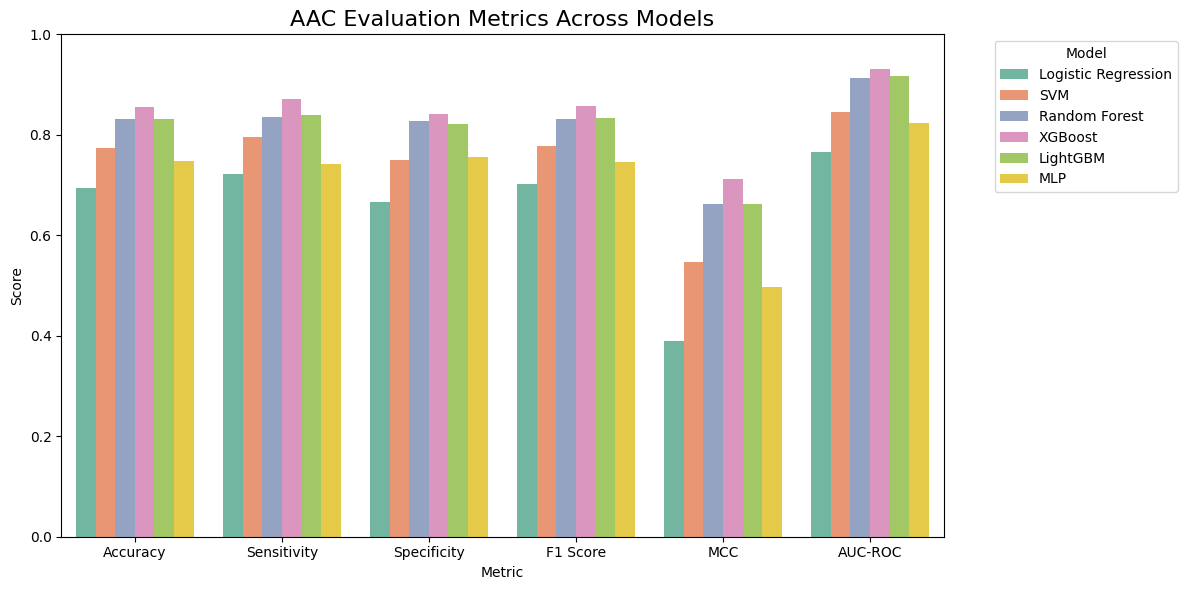

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the evaluation results
results_df = pd.read_csv(file_path + "/AACmodel_evaluation_results.csv")

# Metrics to plot
metrics = ["Accuracy", "Sensitivity", "Specificity", "F1 Score", "MCC", "AUC-ROC"]

# Melt the DataFrame for grouped bar plotting
df_melted = results_df.melt(id_vars=["Model"],
                            value_vars=metrics,
                            var_name="Metric",
                            value_name="Score")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette="Set2")

plt.title("AAC Evaluation Metrics Across Models", fontsize=16)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)  # since most metrics range between 0 and 1
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


###HeatMap

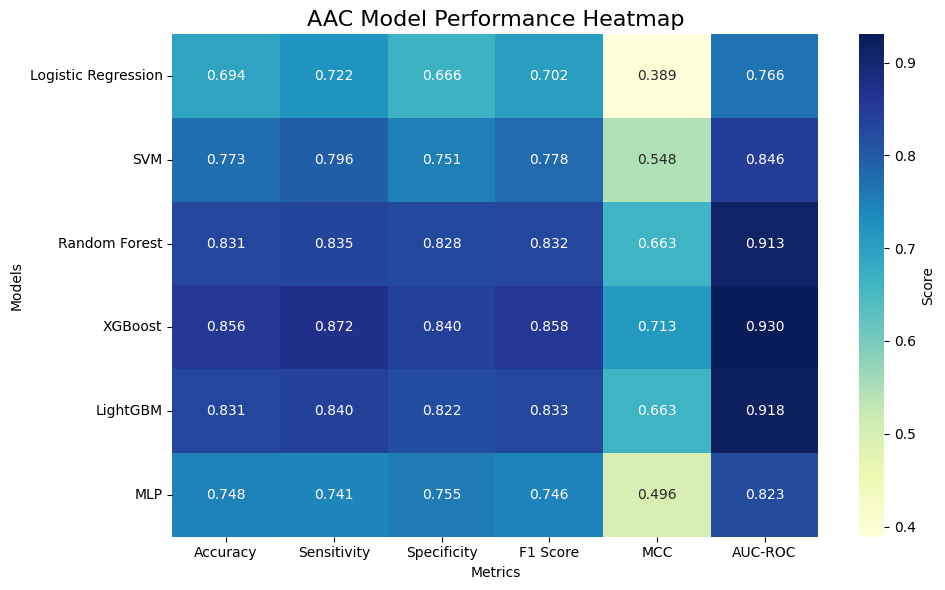

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your results
results_df = pd.read_csv(file_path + "/AACmodel_evaluation_results.csv")

# Set the model names as index
results_df.set_index("Model", inplace=True)

# Select only metric columns (excluding 'Model' if still present)
metrics = ["Accuracy", "Sensitivity", "Specificity", "F1 Score", "MCC", "AUC-ROC"]
heatmap_data = results_df[metrics]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={"label": "Score"})

plt.title("AAC Model Performance Heatmap", fontsize=16)
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.tight_layout()
plt.show()


##Step 9: Cross Validation
Cross validation is another way of training and evaluating the performance of the ML models. Unlike the single train-test split, the model is tested on different subset (fold) of the data and performance is avaerage over the multiple folds.

In K-fold cross validation:
* The dataset is divided into k equal part (k here is  10).
* The ML model are trained on k-1 folds (in this case 9) and tested on the remaining one.
* This process is repeated k times, each with a different test fold every time.
* The final evaluation metrics will then be calculated as the average score across all 10 folds

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np

# Number of folds
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Dictionary to store averaged results
cv_results = []

# Loop through models
for name, model in models.items():
    print(f"Cross-validating: {name}")

    # Lists to hold fold scores
    accs, sens, specs, f1s, mccs, aucs = [], [], [], [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # Scale data if needed
        if name in ["SVM", "Logistic Regression", "MLP"]:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        # Fit model and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        # Confusion matrix
        tn = ((y_val == 0) & (y_pred == 0)).sum()
        fp = ((y_val == 0) & (y_pred == 1)).sum()
        fn = ((y_val == 1) & (y_pred == 0)).sum()
        tp = ((y_val == 1) & (y_pred == 1)).sum()

        # Store scores
        accs.append(accuracy_score(y_val, y_pred))
        sens.append(recall_score(y_val, y_pred))
        specs.append(tn / (tn + fp) if (tn + fp) else 0)
        f1s.append(f1_score(y_val, y_pred))
        mccs.append(matthews_corrcoef(y_val, y_pred))
        aucs.append(roc_auc_score(y_val, y_prob))

    # Save average metrics
    cv_results.append({
        "Model": name,
        "Accuracy": np.mean(accs),
        "Sensitivity": np.mean(sens),
        "Specificity": np.mean(specs),
        "F1 Score": np.mean(f1s),
        "MCC": np.mean(mccs),
        "AUC-ROC": np.mean(aucs),
    })

# Convert to DataFrame
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(file_path + "/cross_validated_results.csv", index=False)
print("Cross-validated results saved as 'cross_validated_results.csv'")


Cross-validating: Logistic Regression
Cross-validating: SVM
Cross-validating: Random Forest
Cross-validating: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:36:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:36:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:36:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:36:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:36:21] WARNING: /w

Cross-validating: LightGBM
[LightGBM] [Info] Number of positive: 4002, number of negative: 4002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 8004, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4002, number of negative: 4002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 8004, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4002, number of negative: 4002
[LightGBM] [Info] Auto-choosin

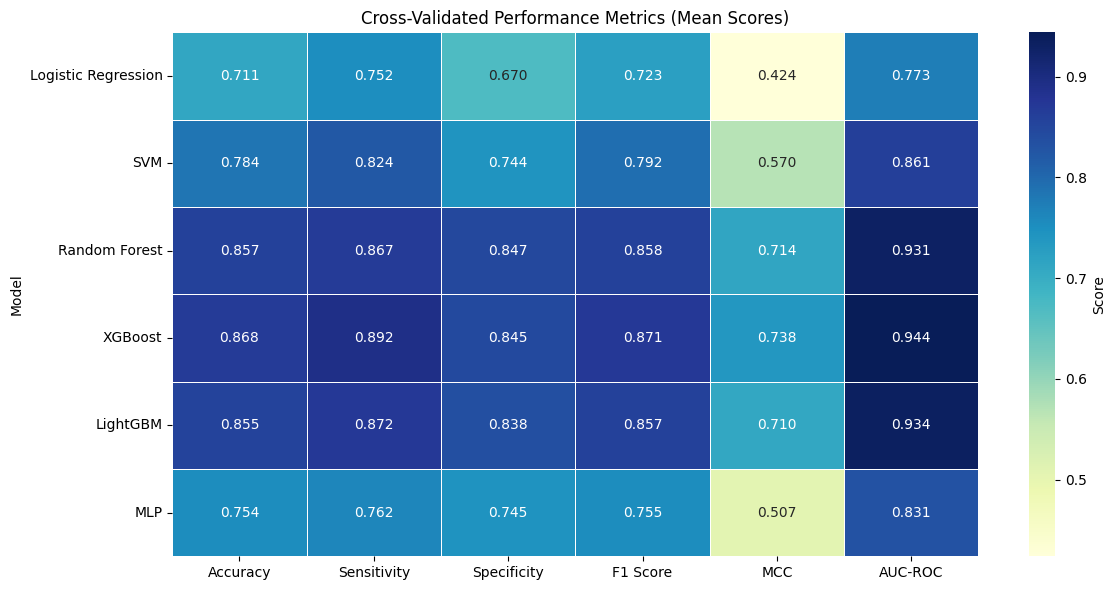

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
plt.figure(figsize=(12, 6))
heatmap_data = cv_df.set_index("Model")  # use Model names as row labels

# Round the values for cleaner display
heatmap_data_rounded = heatmap_data.round(3)

# Create the heatmap
sns.heatmap(
    heatmap_data_rounded,
    annot=True,         # show values in cells
    fmt=".3f",          # format decimals
    cmap="YlGnBu",      # color map
    linewidths=0.5,     # lines between cells
    cbar_kws={'label': 'Score'}
)

plt.title("Cross-Validated Performance Metrics (Mean Scores)")
plt.tight_layout()
plt.show()


##Step 10: Model Deploymment
After identifying the best performing model based on the evaluation metrics from single split training and cross validation, we will retrain the best model using the entire dataset and save the model for reuse on new data without the need for retraining

###Hyperparameter Tuning
Based on our model evaluation result, XGBoost gave the best performance. The hyperparameters of XGBoost is tuned to identify the best parameters to to use for model deployment

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define base model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False
)

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# Perform grid search (10-fold CV)
grid_cv = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_cv.fit(X_train, y_train)

print("Best parameters:", grid_cv.best_params_)
print("Best cross-validated score:", grid_cv.best_score_)


Fitting 10 folds for each of 243 candidates, totalling 2430 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:51:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Best cross-validated score: 0.8824502184769039


###Train the final Model on the entire dataset
We will now retrain this model using the entire dataset (training data and testing data combined) with the best parameters.

In [ ]:
import pandas as pd
from xgboost import XGBClassifier

# Convert NumPy arrays back to DataFrames if needed
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=X.columns)

# Combine them safely
X_full = pd.concat([X_train, X_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)


# Use the best parameters obtained from above
best_params = grid_cv.best_params_

# Train final model on full training data
final_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    **best_params
)

final_xgb.fit(X_train, y_train)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:55:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

###Save the best model

In [ ]:
# Save the model
import joblib
# Save the trained model
# Specify your desired file path
save_path = "/content/my_drive/My Drive/HPI/Features/final_xgb.pkl"

joblib.dump(final_xgb, save_path)

print("Model saved successfully!")


Model saved successfully!


###Use the Saved Model on New Dataset
Once saved, it can be used to make predictions of new HPPPI pair/pairs.

Note: The model was trained using Amino Acid Composition (AAC) features, thus, the model can only be used to make predictions on new data with AAC features.

In [ ]:
#Making predictions on new HP-PPI pairs
import joblib
import pandas as pd

# Load the model
model = joblib.load("/content/my_drive/My Drive/HPI/Features/final_xgb.pkl")

# Load  new data (AAC features only)
new_data = pd.read_csv("new_hppi_aac_features.csv")
predictions = model.predict(new_data)

print(predictions)
